# Notebook 01 — EDA e Limpeza do Dataset **Distribuição de Renda**

**Objetivo:**  
Explorar o dataset bruto (`data/raw/distribuicao-renda.csv`), realizar a análise exploratória de dados (EDA), tratar problemas de qualidade (nulos, outliers, tipos) e gerar um dataset limpo para uso posterior na clusterização.

**Etapas:**
1. Carregamento e inspeção inicial.  
2. Estatísticas descritivas e distribuição das variáveis.  
3. Identificação e tratamento de nulos.  
4. Identificação e tratamento de outliers.  
5. Salvamento de versão limpa em `data/processed/`.  


## 1. Importação de pacotes e configuração de paths


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configurações globais
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

# Paths
ROOT = Path.cwd().resolve().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA_RAW = ROOT / "data" / "raw"
DATA_PROCESSED = ROOT / "data" / "processed"
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

RAW_FILE = DATA_RAW / "distribuicao-renda.csv"
print("Arquivo bruto:", RAW_FILE.exists(), RAW_FILE)


Arquivo bruto: True C:\QuartoSemestre\kmeans-3d-cluster\data\raw\distribuicao-renda.csv


## 2. Carregamento inicial do dataset bruto
- Verificar número de linhas e colunas.  
- Conferir nomes das variáveis.  
- Observar amostra inicial.


In [14]:
# Carregar dataset bruto
df = pd.read_csv(RAW_FILE, sep=";", encoding="utf-8")

# Visualizar shape e primeiras linhas
print("Shape:", df.shape)
df.head()


Shape: (46350, 24)


,Ano-calendário,Ente Federativo,Centil,Quantidade de Contribuintes,Rendimentos Tributaveis - Limite Superior da RTB do Centil [R$ milhões],Rendimentos Tributaveis - Soma da RTB do Centil [R$ milhões],Rendimentos Tributaveis - RTB Acumulada do Centil [R$ milhões],Rendimentos Tributaveis - Média da RTB do Centil [R$],Rendimentos Sujeitos à Tribut. Exclusiva [R$ milhões],Rendimentos Isentos - Lucros e dividendos [R$ milhões],Rendimentos Isentos - Rendim. Sócio/Titular ME/EPP Opt SIMPLES [R$ milhões],Rendimentos Isentos - Outros Rendimentos Isentos [R$ milhões],Despesas Dedutíveis - Previdência [R$ milhões],Despesas Dedutíveis - Dependentes [R$ milhões],Despesas Dedutíveis - Instrução [R$ milhões],Despesas Dedutíveis - Médicas [R$ milhões],Despesas Dedutíveis - Pensão Alimentícia [R$ milhões],Despesas Dedutíveis - Livro-Caixa [R$ milhões],Imposto Devido [R$ milhões],Bens e Direitos - Imóveis [R$ milhões],Bens e Direitos - Móveis [R$ milhões],Bens e Direitos - Financeiros [R$ milhões],Bens e Direitos - Outros Bens e Direitos [R$ milhões],Dívidas e Ônus [R$ milhões]
0,2006,BRASIL,1,241.563,NaN,NaN,NaN,NaN,"235,61","481,27","27,37","1.694,49",NaN,NaN,NaN,NaN,NaN,NaN,"0,16","5.281,59","686,21","6.549,15","1.006,40","1.610,39"
1,2006,BRASIL,2,241.563,NaN,NaN,NaN,NaN,"208,74","483,44","29,36","1.675,01",NaN,NaN,NaN,NaN,NaN,NaN,"0,22","5.295,48","668,82","5.762,77","681,75","694,12"
2,2006,BRASIL,3,241.562,NaN,NaN,NaN,NaN,"219,96","459,87","27,63","1.683,04",NaN,NaN,NaN,NaN,NaN,NaN,"0,31","5.566,27","670,64","5.451,95","377,17","650,98"
3,2006,BRASIL,4,241.563,NaN,NaN,NaN,NaN,"257,01","481,93","31,77","1.699,89",NaN,NaN,NaN,NaN,NaN,NaN,"0,17","5.860,02","678,44","6.104,09","256,16","1.079,20"
4,2006,BRASIL,5,241.562,NaN,NaN,NaN,NaN,"249,88","464,23","28,11","1.697,17",NaN,NaN,NaN,NaN,NaN,NaN,"0,17","5.193,31","682,38","5.592,52","269,28","671,97"


## 3. Checagens iniciais
- Tipos de dados de cada coluna.  
- Presença de valores nulos.  
- Presença de duplicados.  


In [15]:
# Tipos das colunas
print("Tipos de dados:")
print(df.dtypes)

# Contagem de nulos
print("\nValores nulos por coluna:")
print(df.isna().sum())

# Duplicados
print("\nLinhas duplicadas:", df.duplicated().sum())


Tipos de dados:
Ano-calendário                                                                   int64
Ente Federativo                                                                 object
Centil                                                                          object
Quantidade de Contribuintes                                                    float64
Rendimentos Tributaveis - Limite Superior da RTB do Centil [R$ milhões]         object
Rendimentos Tributaveis - Soma da RTB do Centil [R$ milhões]                    object
Rendimentos Tributaveis - RTB Acumulada do Centil [R$ milhões]                  object
Rendimentos Tributaveis - Média da RTB do Centil [R$]                           object
Rendimentos Sujeitos à Tribut. Exclusiva [R$ milhões]                           object
Rendimentos Isentos - Lucros e dividendos [R$ milhões]                          object
Rendimentos Isentos - Rendim. Sócio/Titular ME/EPP Opt SIMPLES [R$ milhões]     object
Rendimentos Isentos - Outro

### 3.1 Conversão de tipos (object → numérico)

Grande parte das variáveis numéricas foi carregada como **texto (object)**, 
pois os valores estão no formato brasileiro (ponto `.` para milhar e vírgula `,` para decimal).

Nesta etapa:
- Identificamos colunas `object` que representam números.  
- Convertemos para `float` (pt-BR → padrão internacional).  
- Ajustamos `Centil` e outras colunas categóricas/numericamente discretas para tipos adequados.  

Esse passo é **fundamental** para que a análise descritiva (célula 4) funcione corretamente.


In [16]:
# 3.1 — Conversão de colunas "object" com números em formato BR para float

import numpy as np
import re

def looks_numeric_br(val: str) -> bool:
    """
    Heurística: detecta strings com dígitos em formato brasileiro:
    - milhares com ponto: 1.234.567
    - decimais com vírgula: 123,45
    - aceita espaços; vazio/None retorna False
    """
    if val is None or (isinstance(val, float) and np.isnan(val)):
        return False
    s = str(val).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return False
    # Ex.: 1.234,56 | 123,45 | 123456 | 1.234.567 | -1.234,56
    pattern = r"""^\s*[-+]?\d{1,3}(\.\d{3})*(,\d+)?\s*$|^\s*[-+]?\d+(,\d+)?\s*$"""
    return re.match(pattern, s) is not None

def br_to_float(series: pd.Series) -> pd.Series:
    """
    Converte série com números em pt-BR (ponto como milhar, vírgula como decimal) para float.
    Strings vazias, 'NaN', '-' viram NaN.
    """
    s = series.astype(str).str.strip()
    s = s.replace({"": np.nan, "-": np.nan, "NaN": np.nan, "nan": np.nan})
    # remove separador de milhar "." e troca vírgula decimal por "."
    s = s.str.replace(".", "", regex=False).str.replace(",", ".", regex=False)
    return pd.to_numeric(s, errors="coerce")

# 1) Identificar colunas object candidatas (>=60% parecem números BR)
object_cols = [c for c in df.columns if df[c].dtype == "object"]

candidate_numeric_cols = []
for c in object_cols:
    sample = df[c].dropna().astype(str).head(500)  # amostra p/ acelerar
    if len(sample) == 0:
        continue
    frac_numeric_like = sample.apply(looks_numeric_br).mean()
    if frac_numeric_like >= 0.60:
        candidate_numeric_cols.append(c)

print("Candidatas a numéricas (pt-BR):")
for c in candidate_numeric_cols:
    print(" -", c)

# 2) Converter candidatas para float
df_conv = df.copy()
for c in candidate_numeric_cols:
    before_nonnull = df_conv[c].notna().sum()
    df_conv[c] = br_to_float(df_conv[c])
    after_nonnull = df_conv[c].notna().sum()
    print(f"[ok] {c}: não-nulos antes={before_nonnull} | depois={after_nonnull}")

# 3) Ajustar colunas específicas
# Centil deve ser inteiro (pode vir como texto); usa inteiro nulo-capaz (Int64)
if df_conv["Centil"].dtype == "object":
    df_conv["Centil"] = pd.to_numeric(df_conv["Centil"], errors="coerce").astype("Int64")

# Quantidade de Contribuintes já está float64 — se você quiser inteiro:
# (só faça se tiver certeza de que não há frações)
# df_conv["Quantidade de Contribuintes"] = pd.to_numeric(
#     df_conv["Quantidade de Contribuintes"], errors="coerce"
# ).round().astype("Int64")

print("\nTipos após conversão:\n", df_conv.dtypes)

# Substitui df pelo convertido para as próximas células do notebook
df = df_conv

# Visualização rápida
df.head()


Candidatas a numéricas (pt-BR):
 - Centil
 - Rendimentos Tributaveis - Limite Superior da RTB do Centil [R$ milhões]
 - Rendimentos Tributaveis - Soma da RTB do Centil [R$ milhões]
 - Rendimentos Tributaveis - RTB Acumulada do Centil [R$ milhões]
 - Rendimentos Tributaveis - Média da RTB do Centil [R$]
 - Rendimentos Sujeitos à Tribut. Exclusiva [R$ milhões]
 - Rendimentos Isentos - Lucros e dividendos [R$ milhões]
 - Rendimentos Isentos - Rendim. Sócio/Titular ME/EPP Opt SIMPLES [R$ milhões]
 - Rendimentos Isentos - Outros Rendimentos Isentos [R$ milhões]
 - Despesas Dedutíveis - Previdência [R$ milhões]
 - Despesas Dedutíveis - Dependentes [R$ milhões]
 - Despesas Dedutíveis - Instrução [R$ milhões]
 - Despesas Dedutíveis - Médicas [R$ milhões]
 - Despesas Dedutíveis - Pensão Alimentícia [R$ milhões]
 - Despesas Dedutíveis - Livro-Caixa [R$ milhões]
 - Imposto Devido [R$ milhões]
 - Bens e Direitos - Imóveis [R$ milhões]
 - Bens e Direitos - Móveis [R$ milhões]
 - Bens e Direitos - F

,Ano-calendário,Ente Federativo,Centil,Quantidade de Contribuintes,Rendimentos Tributaveis - Limite Superior da RTB do Centil [R$ milhões],Rendimentos Tributaveis - Soma da RTB do Centil [R$ milhões],Rendimentos Tributaveis - RTB Acumulada do Centil [R$ milhões],Rendimentos Tributaveis - Média da RTB do Centil [R$],Rendimentos Sujeitos à Tribut. Exclusiva [R$ milhões],Rendimentos Isentos - Lucros e dividendos [R$ milhões],Rendimentos Isentos - Rendim. Sócio/Titular ME/EPP Opt SIMPLES [R$ milhões],Rendimentos Isentos - Outros Rendimentos Isentos [R$ milhões],Despesas Dedutíveis - Previdência [R$ milhões],Despesas Dedutíveis - Dependentes [R$ milhões],Despesas Dedutíveis - Instrução [R$ milhões],Despesas Dedutíveis - Médicas [R$ milhões],Despesas Dedutíveis - Pensão Alimentícia [R$ milhões],Despesas Dedutíveis - Livro-Caixa [R$ milhões],Imposto Devido [R$ milhões],Bens e Direitos - Imóveis [R$ milhões],Bens e Direitos - Móveis [R$ milhões],Bens e Direitos - Financeiros [R$ milhões],Bens e Direitos - Outros Bens e Direitos [R$ milhões],Dívidas e Ônus [R$ milhões]
0,2006,BRASIL,1,241.563,NaN,NaN,NaN,NaN,235.61,481.27,27.37,1694.49,NaN,NaN,NaN,NaN,NaN,NaN,0.16,5281.59,686.21,6549.15,1006.40,1610.39
1,2006,BRASIL,2,241.563,NaN,NaN,NaN,NaN,208.74,483.44,29.36,1675.01,NaN,NaN,NaN,NaN,NaN,NaN,0.22,5295.48,668.82,5762.77,681.75,694.12
2,2006,BRASIL,3,241.562,NaN,NaN,NaN,NaN,219.96,459.87,27.63,1683.04,NaN,NaN,NaN,NaN,NaN,NaN,0.31,5566.27,670.64,5451.95,377.17,650.98
3,2006,BRASIL,4,241.563,NaN,NaN,NaN,NaN,257.01,481.93,31.77,1699.89,NaN,NaN,NaN,NaN,NaN,NaN,0.17,5860.02,678.44,6104.09,256.16,1079.20
4,2006,BRASIL,5,241.562,NaN,NaN,NaN,NaN,249.88,464.23,28.11,1697.17,NaN,NaN,NaN,NaN,NaN,NaN,0.17,5193.31,682.38,5592.52,269.28,671.97


## 4. Estatísticas descritivas
- Medidas resumo para todas as variáveis numéricas.  
- Distribuições (histogramas).  
- Relações entre variáveis (correlação).  


In [17]:
# Estatísticas básicas
df.describe(include="all").transpose()


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Ano-calendário,46350.0,NaN,NaN,NaN,2013.0,4.32054,2006.0,2009.0,2013.0,2017.0,2020.0
Ente Federativo,46350,28,BRASIL,1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Centil,46350.0,NaN,NaN,NaN,833.946602,18808.8177,1.0,28.0,56.0,83.0,1001010.0
Quantidade de Contribuintes,46350.0,NaN,NaN,NaN,96.555265,197.999486,1.001,2.894,6.79,29.169,993.0
Rendimentos Tributaveis - Limite Superior da RTB do Centil [R$ milhões],42935.0,NaN,NaN,NaN,591921.059514,8525088.92852,0.0,22200.0,36000.0,76668.79,429364667.06
Rendimentos Tributaveis - Soma da RTB do Centil [R$ milhões],42935.0,NaN,NaN,NaN,1006.819965,4610.819738,0.0,55.64,150.48,467.39,212033.29
Rendimentos Tributaveis - RTB Acumulada do Centil [R$ milhões],42935.0,NaN,NaN,NaN,22983.078734,92996.886271,0.0,757.79,3072.1,10944.75,1975433.24
Rendimentos Tributaveis - Média da RTB do Centil [R$],42935.0,NaN,NaN,NaN,93269.688331,197962.167508,0.0,21945.275,35709.26,74931.78,8358880.64
Rendimentos Sujeitos à Tribut. Exclusiva [R$ milhões],46219.0,NaN,NaN,NaN,166.247231,1102.930733,0.0,3.23,12.32,51.95,64340.39
Rendimentos Isentos - Lucros e dividendos [R$ milhões],45891.0,NaN,NaN,NaN,168.899223,884.071432,0.0,3.16,14.51,63.925,45567.3


### 4.1 Limpeza após `describe()` e recorte para K-Means

- **Centil** deve estar no intervalo **1..100**. Vamos remover linhas fora desse intervalo.
- Definimos a unidade da análise como (**Ano-calendário**, **Ente Federativo**, **Centil**).
- Selecionaremos 3 variáveis contínuas com maior completude:
  - `Bens e Direitos - Imóveis [R$ milhões]`
  - `Bens e Direitos - Financeiros [R$ milhões]`
  - `Dívidas e Ônus [R$ milhões]`
- Removeremos apenas linhas com `NaN` **nessas três variáveis** (não em todo o dataset).
- Não aplicaremos normalização aqui; isso fica para a etapa de modelagem.


In [20]:
# Colunas escolhidas para o K-Means 3D (as mais completas)
COL_IMOVEIS = "Bens e Direitos - Imóveis [R$ milhões]"
COL_FINANC  = "Bens e Direitos - Financeiros [R$ milhões]"
COL_DIVIDAS = "Dívidas e Ônus [R$ milhões]"

# 1) Garantir que 'Centil' é inteiro e filtrar para [1..100]
if str(df["Centil"].dtype) != "Int64" and str(df["Centil"].dtype) != "int64":
    df["Centil"] = pd.to_numeric(df["Centil"], errors="coerce").astype("Int64")

rows_before = len(df)
df = df[(df["Centil"].notna()) & (df["Centil"] >= 1) & (df["Centil"] <= 100)]
print(f"Linhas removidas por 'Centil' fora de [1..100] ou NaN: {rows_before - len(df)}")

# 2) Checar existência das colunas escolhidas
for c in [COL_IMOVEIS, COL_FINANC, COL_DIVIDAS]:
    if c not in df.columns:
        raise KeyError(f"Coluna não encontrada: {c}")

# 3) Subset focado (mantendo chaves para rastreabilidade)
cols_keep = ["Ano-calendário", "Ente Federativo", "Centil", 
             "Quantidade de Contribuintes", COL_IMOVEIS, COL_FINANC, COL_DIVIDAS]
df_k = df[cols_keep].copy()

# 4) Remover NaNs apenas nas 3 variáveis do K-Means
na_before = df_k[[COL_IMOVEIS, COL_FINANC, COL_DIVIDAS]].isna().sum().to_dict()
rows_before = len(df_k)
df_k = df_k.dropna(subset=[COL_IMOVEIS, COL_FINANC, COL_DIVIDAS])
rows_after = len(df_k)
na_after = df_k[[COL_IMOVEIS, COL_FINANC, COL_DIVIDAS]].isna().sum().to_dict()

print("NaNs por coluna (antes):", na_before)
print("NaNs por coluna (depois):", na_after)
print(f"Linhas removidas por NaN nessas 3 colunas: {rows_before - rows_after}")

# 5) Conferência rápida
display(df_k.head())
print("Shape do dataset para K-Means:", df_k.shape)


Linhas removidas por 'Centil' fora de [1..100] ou NaN: 0
NaNs por coluna (antes): {'Bens e Direitos - Imóveis [R$ milhões]': 45, 'Bens e Direitos - Financeiros [R$ milhões]': 2, 'Dívidas e Ônus [R$ milhões]': 133}
NaNs por coluna (depois): {'Bens e Direitos - Imóveis [R$ milhões]': 0, 'Bens e Direitos - Financeiros [R$ milhões]': 0, 'Dívidas e Ônus [R$ milhões]': 0}
Linhas removidas por NaN nessas 3 colunas: 133


,Ano-calendário,Ente Federativo,Centil,Quantidade de Contribuintes,Bens e Direitos - Imóveis [R$ milhões],Bens e Direitos - Financeiros [R$ milhões],Dívidas e Ônus [R$ milhões]
0,2006,BRASIL,1,241.563,5281.59,6549.15,1610.39
1,2006,BRASIL,2,241.563,5295.48,5762.77,694.12
2,2006,BRASIL,3,241.562,5566.27,5451.95,650.98
3,2006,BRASIL,4,241.563,5860.02,6104.09,1079.20
4,2006,BRASIL,5,241.562,5193.31,5592.52,671.97


Shape do dataset para K-Means: (41867, 7)


## 5. Tratamento de valores nulos
- Estratégia adotada (remoção, imputação, preenchimento com média/mediana).  
- Justificativa da decisão.  


In [21]:
# 5 — Tratamento de valores nulos

target_cols = [COL_IMOVEIS, COL_FINANC, COL_DIVIDAS]

# Remover valores negativos e reforçar remoção de NaN nessas variáveis
for c in target_cols:
    df_k[c] = pd.to_numeric(df_k[c], errors="coerce")
    neg_count = (df_k[c] < 0).sum()
    if neg_count > 0:
        print(f"Ajuste: {c} tinha {neg_count} valores negativos → convertidos em NaN")
        df_k.loc[df_k[c] < 0, c] = np.nan

rows_before = len(df_k)
df_k = df_k.dropna(subset=target_cols)
print(f"Linhas removidas por NaN nessas 3 colunas: {rows_before - len(df_k)}")
print("Shape após remoção de nulos:", df_k.shape)


Linhas removidas por NaN nessas 3 colunas: 0
Shape após remoção de nulos: (41867, 7)


## 6. Tratamento de outliers
- Método escolhido (ex.: IQR, Z-score, winsorização).  
- Justificativa da decisão.  


In [22]:
# 6 — Tratamento de outliers com IQR (winsorização)

def iqr_winsorize(series: pd.Series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    li = q1 - k * iqr
    ls = q3 + k * iqr
    capped = series.clip(lower=li, upper=ls)
    return capped, (float(li), float(ls))

winsor_report = {}
df_k_w = df_k.copy()

for c in target_cols:
    before = df_k_w[c].copy()
    df_k_w[c], (li, ls) = iqr_winsorize(df_k_w[c])
    changed = (before != df_k_w[c]).sum()
    winsor_report[c] = {"lim_inferior": li, "lim_superior": ls, "valores_ajustados": int(changed)}

print("Relatório winsorização (IQR):")
winsor_report


Relatório winsorização (IQR):


{'Bens e Direitos - Imóveis [R$ milhões]': {'lim_inferior': -1036.9925,
  'lim_superior': 1864.5075000000002,
  'valores_ajustados': 5760},
 'Bens e Direitos - Financeiros [R$ milhões]': {'lim_inferior': -885.6774999999999,
  'lim_superior': 1576.3425,
  'valores_ajustados': 6274},
 'Dívidas e Ônus [R$ milhões]': {'lim_inferior': -205.00750000000002,
  'lim_superior': 364.4525,
  'valores_ajustados': 5612}}

## 7. Dataset limpo
- Visualizar primeiras linhas após tratamento.  
- Confirmar que não existem mais nulos.  
- Confirmar coerência das distribuições.  


Shape final: (41867, 7)


,Ano-calendário,Ente Federativo,Centil,Quantidade de Contribuintes,Bens e Direitos - Imóveis [R$ milhões],Bens e Direitos - Financeiros [R$ milhões],Dívidas e Ônus [R$ milhões]
0,2006,BRASIL,1,241.563,1864.5075,1576.3425,364.4525
1,2006,BRASIL,2,241.563,1864.5075,1576.3425,364.4525
2,2006,BRASIL,3,241.562,1864.5075,1576.3425,364.4525
3,2006,BRASIL,4,241.563,1864.5075,1576.3425,364.4525
4,2006,BRASIL,5,241.562,1864.5075,1576.3425,364.4525


,count,mean,std,min,25%,50%,75%,max
Bens e Direitos - Imóveis [R$ milhões],41867.0,522.999887,657.417619,0.03,51.07,176.15,776.445,1864.5075
Bens e Direitos - Financeiros [R$ milhões],41867.0,444.713048,565.970811,0.00,37.58,145.19,653.085,1576.3425
Dívidas e Ônus [R$ milhões],41867.0,100.896866,128.069837,0.00,8.54,34.39,150.905,364.4525


C:\Users\ander\AppData\Local\Temp\ipykernel_15656\2964610884.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_k_w[c].values for c in target_cols], labels=target_cols, showmeans=True)


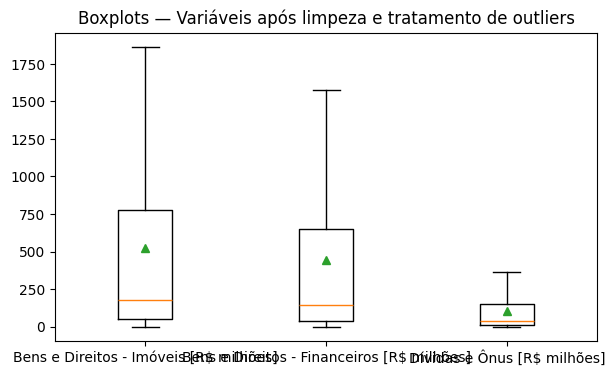

In [23]:
# 7 — Dataset limpo (visualizações básicas pós-limpeza/outliers)

print("Shape final:", df_k_w.shape)

# Visualizar primeiras linhas
display(df_k_w.head())

# Estatísticas descritivas
display(df_k_w[target_cols].describe().T)

# Boxplots para confirmar coerência das distribuições
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.boxplot([df_k_w[c].values for c in target_cols], labels=target_cols, showmeans=True)
plt.title("Boxplots — Variáveis após limpeza e tratamento de outliers")
plt.show()


**Interpretação dos boxplots:**
- *Imóveis* apresenta grande dispersão, com a maioria dos valores concentrada abaixo da mediana e alguns entes/centis acumulando valores muito altos.
- *Financeiros* segue padrão semelhante, mas menos extremo.
- *Dívidas* é mais compacta, com valores relativamente baixos e distribuição menos assimétrica.
- O tratamento de outliers reduziu distorções sem eliminar a variabilidade natural dos dados.


## 8. Salvamento do dataset limpo
Salvar em `data/processed/distribuicao-renda-clean.csv` para uso posterior na clusterização.


In [24]:
# 8 — Salvamento do dataset limpo + metadados

import json
from datetime import datetime

OUTPUT_DIR = DATA_PROCESSED
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

OUT_CSV = OUTPUT_DIR / "distribuicao-renda-clean-3vars.csv"
df_k_w.to_csv(OUT_CSV, index=False, encoding="utf-8")

meta = {
    "generated_at": datetime.now().isoformat(timespec="seconds"),
    "unit_of_analysis": ["Ano-calendário", "Ente Federativo", "Centil"],
    "features": target_cols,
    "cleaning": {
        "removed_nulls": True,
        "iqr_winsorization": winsor_report,
    },
    "shape_final": list(map(int, df_k_w.shape))
}

OUT_META = OUTPUT_DIR / "distribuicao-renda-clean-3vars.metadata.json"
with open(OUT_META, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print("✔ Dataset salvo em:", OUT_CSV.resolve())
print("✔ Metadata salva em:", OUT_META.resolve())


✔ Dataset salvo em: C:\QuartoSemestre\kmeans-3d-cluster\data\processed\distribuicao-renda-clean-3vars.csv
✔ Metadata salva em: C:\QuartoSemestre\kmeans-3d-cluster\data\processed\distribuicao-renda-clean-3vars.metadata.json


## 9. Próximos passos
- Avaliar se a clusterização será feita:
  - Com todos os dados disponíveis,  
  - Com dois anos específicos,  
  - Ou com apenas um ano.  

Essa decisão será baseada na análise criteriosa do dataset limpo.
